In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV
# !pip install xgboost
from xgboost import XGBRegressor
from sklearn.metrics import root_mean_squared_error

In [2]:
data = pd.read_csv("train.csv", index_col=0)
train_with_y = data

In [3]:
# overview of data
data = data.drop("SalePrice", axis = 1)

# count number of variable per type
num_vars = data.select_dtypes(include='number').shape[1]

# Count categorical variables (object or category types)
cat_vars = data.select_dtypes(include=['object', 'category']).shape[1]

print(f"Number of numeric variables: {num_vars}")
print(f"Number of categorical variables: {cat_vars}")

Number of numeric variables: 36
Number of categorical variables: 43


In [4]:
# combine and drop variables
# there is a variable for total basement area (TotalBsmtSF)
data = data.drop(["BsmtFinSF1","BsmtFinSF2"], axis = 1)

# sum up porch areas
data["PorchArea"] = data["OpenPorchSF"] + data["EnclosedPorch"] + data["3SsnPorch"] + data["ScreenPorch"]
data = data.drop(["OpenPorchSF", "EnclosedPorch", "3SsnPorch", "ScreenPorch"], axis = 1)

# sum up bathrooms
data["Baths"] = data["BsmtFullBath"] + data["BsmtHalfBath"] + data["FullBath"] + data["HalfBath"]
data = data.drop(["BsmtFullBath", "BsmtHalfBath", "FullBath", "HalfBath"], axis = 1)

In [5]:
# numeric variables
numeric_ = data.select_dtypes(exclude=['object']).drop(['MSSubClass'], axis=1).copy()

# discontinuous and continuous
disc_num_var = ['OverallQual','OverallCond','Baths','BedroomAbvGr', 'KitchenAbvGr', 
                'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'MoSold', 'YrSold']

cont_num_var = []
for i in numeric_.columns:
    if i not in disc_num_var:
        cont_num_var.append(i)

In [6]:
# redefine variables
num_vars = data.select_dtypes(include='number')
cat_vars = data.select_dtypes(include=['object', 'category'])

##  For continous random variables we do distribution plot: Boxplots

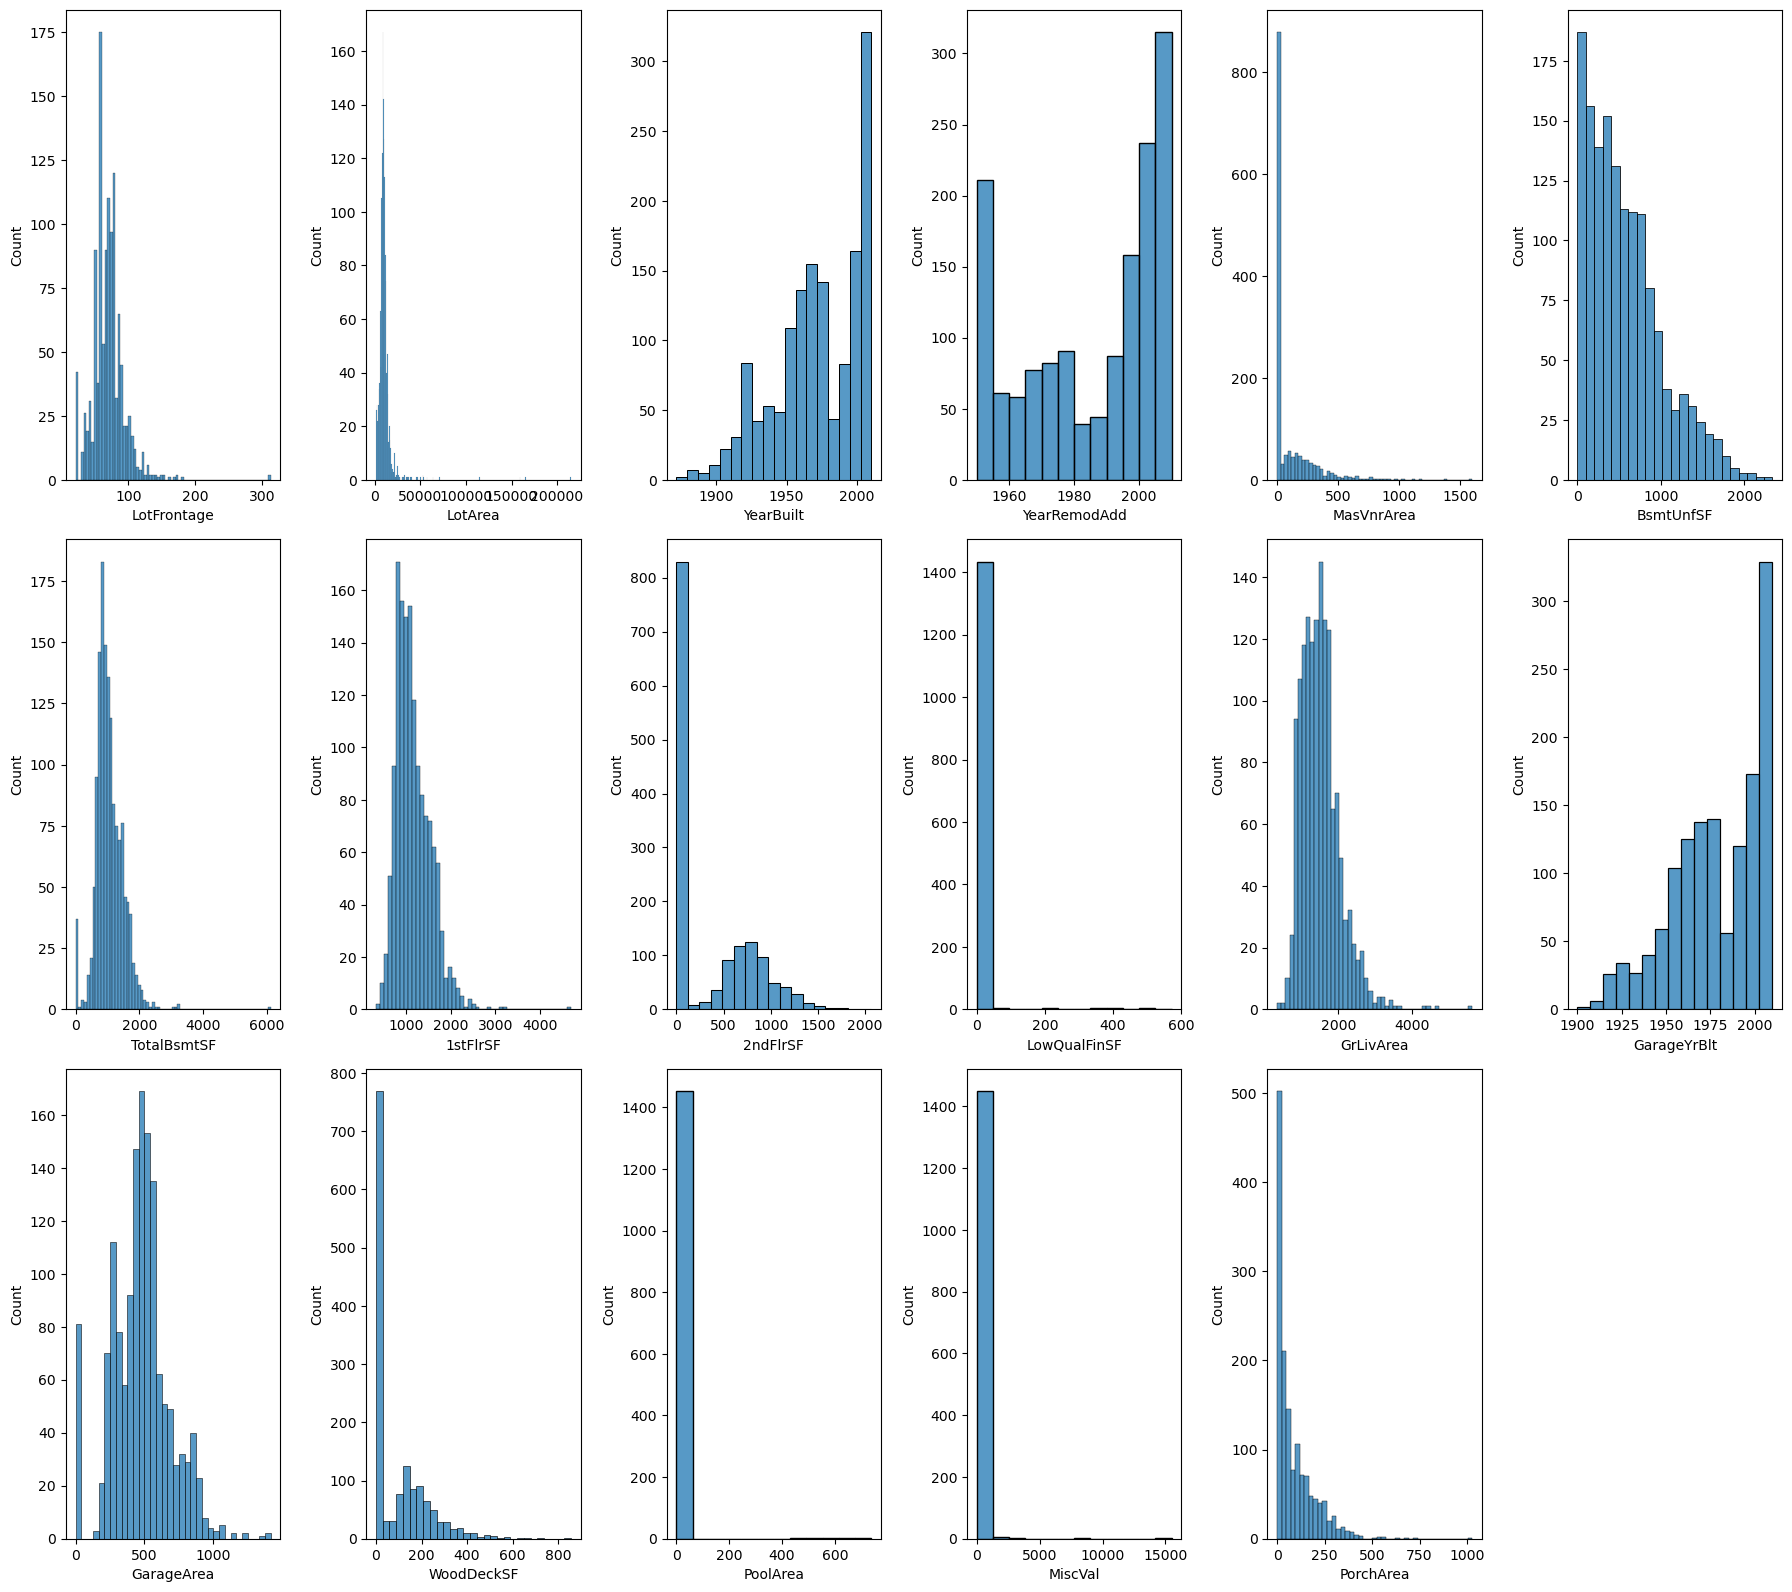

In [8]:
fig = plt.figure(figsize=(18,16))
for index,col in enumerate(cont_num_var):
    plt.subplot(3,6,index+1)
    sns.histplot(numeric_.loc[:,col].dropna(), kde=False)
fig.tight_layout(pad=1.0)

### Variables with Mostly One Value (Highly Skewed Features)

From the distribution plots above, the following variables exhibit highly skewed distributions, with most values being 0:

- `LowQualFinSF`
- `PoolArea`
- `MiscVal`

These features provide little to no useful information for predicting housing prices due to the dominance of a single value (mostly 0s). Therefore, we will **remove them during the preprocessing step** to simplify the model and reduce noise.


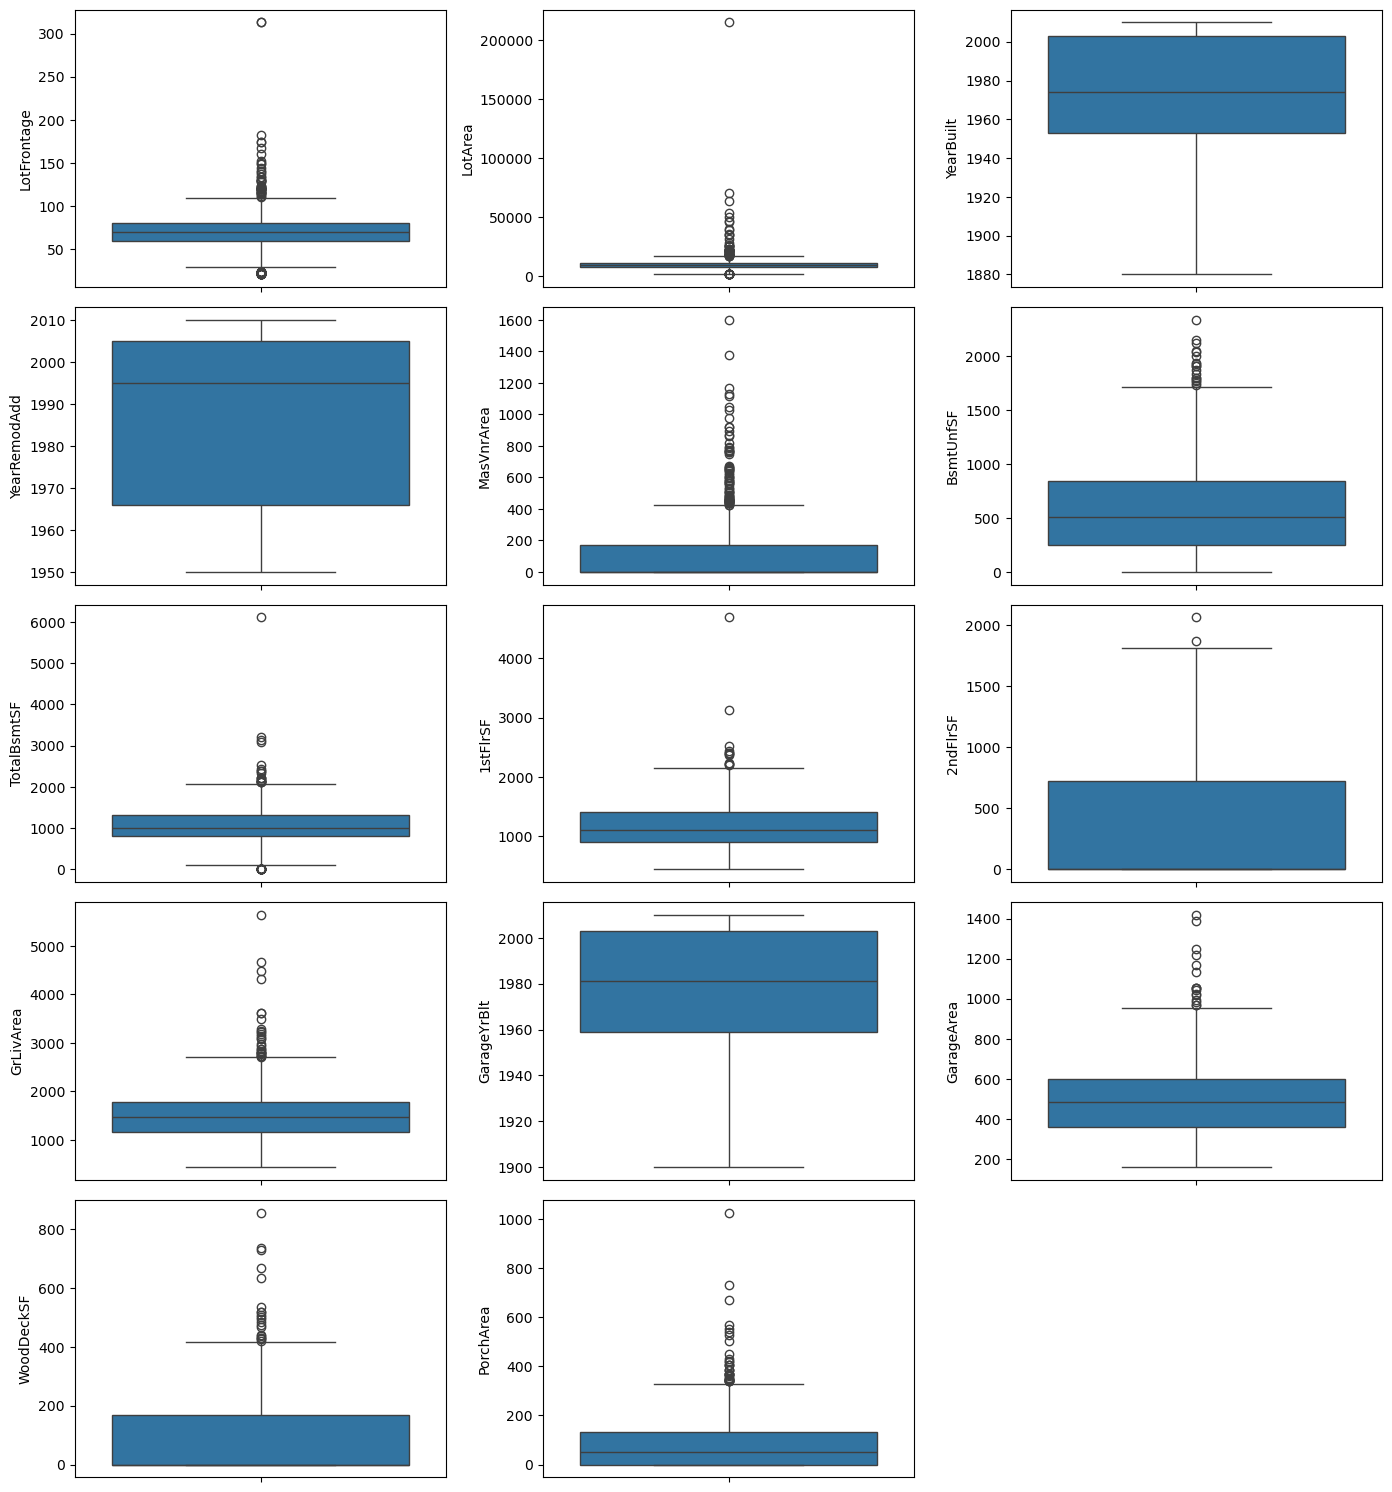

In [10]:
values_to_remove = ["LowQualFinSF", "PoolArea", "MiscVal"]
data = data.drop(values_to_remove, axis = 1)
cont_num_var = [x for x in cont_num_var if x not in values_to_remove]
fig = plt.figure(figsize=(14,15))
for index,col in enumerate(cont_num_var):
    plt.subplot(5,3,index+1)
    sns.boxplot(y=col, data=numeric_.dropna())
fig.tight_layout(pad=1.0)

Removing outliers will prevent our models performance from being affected by extreme values.
From our boxplot earlier, we have pinpointed the following features with extreme outliers:

- LotFrontage
- LotArea
- MasVnrArea
- TotalBsmtSF
- GrLivArea
- PorchArea

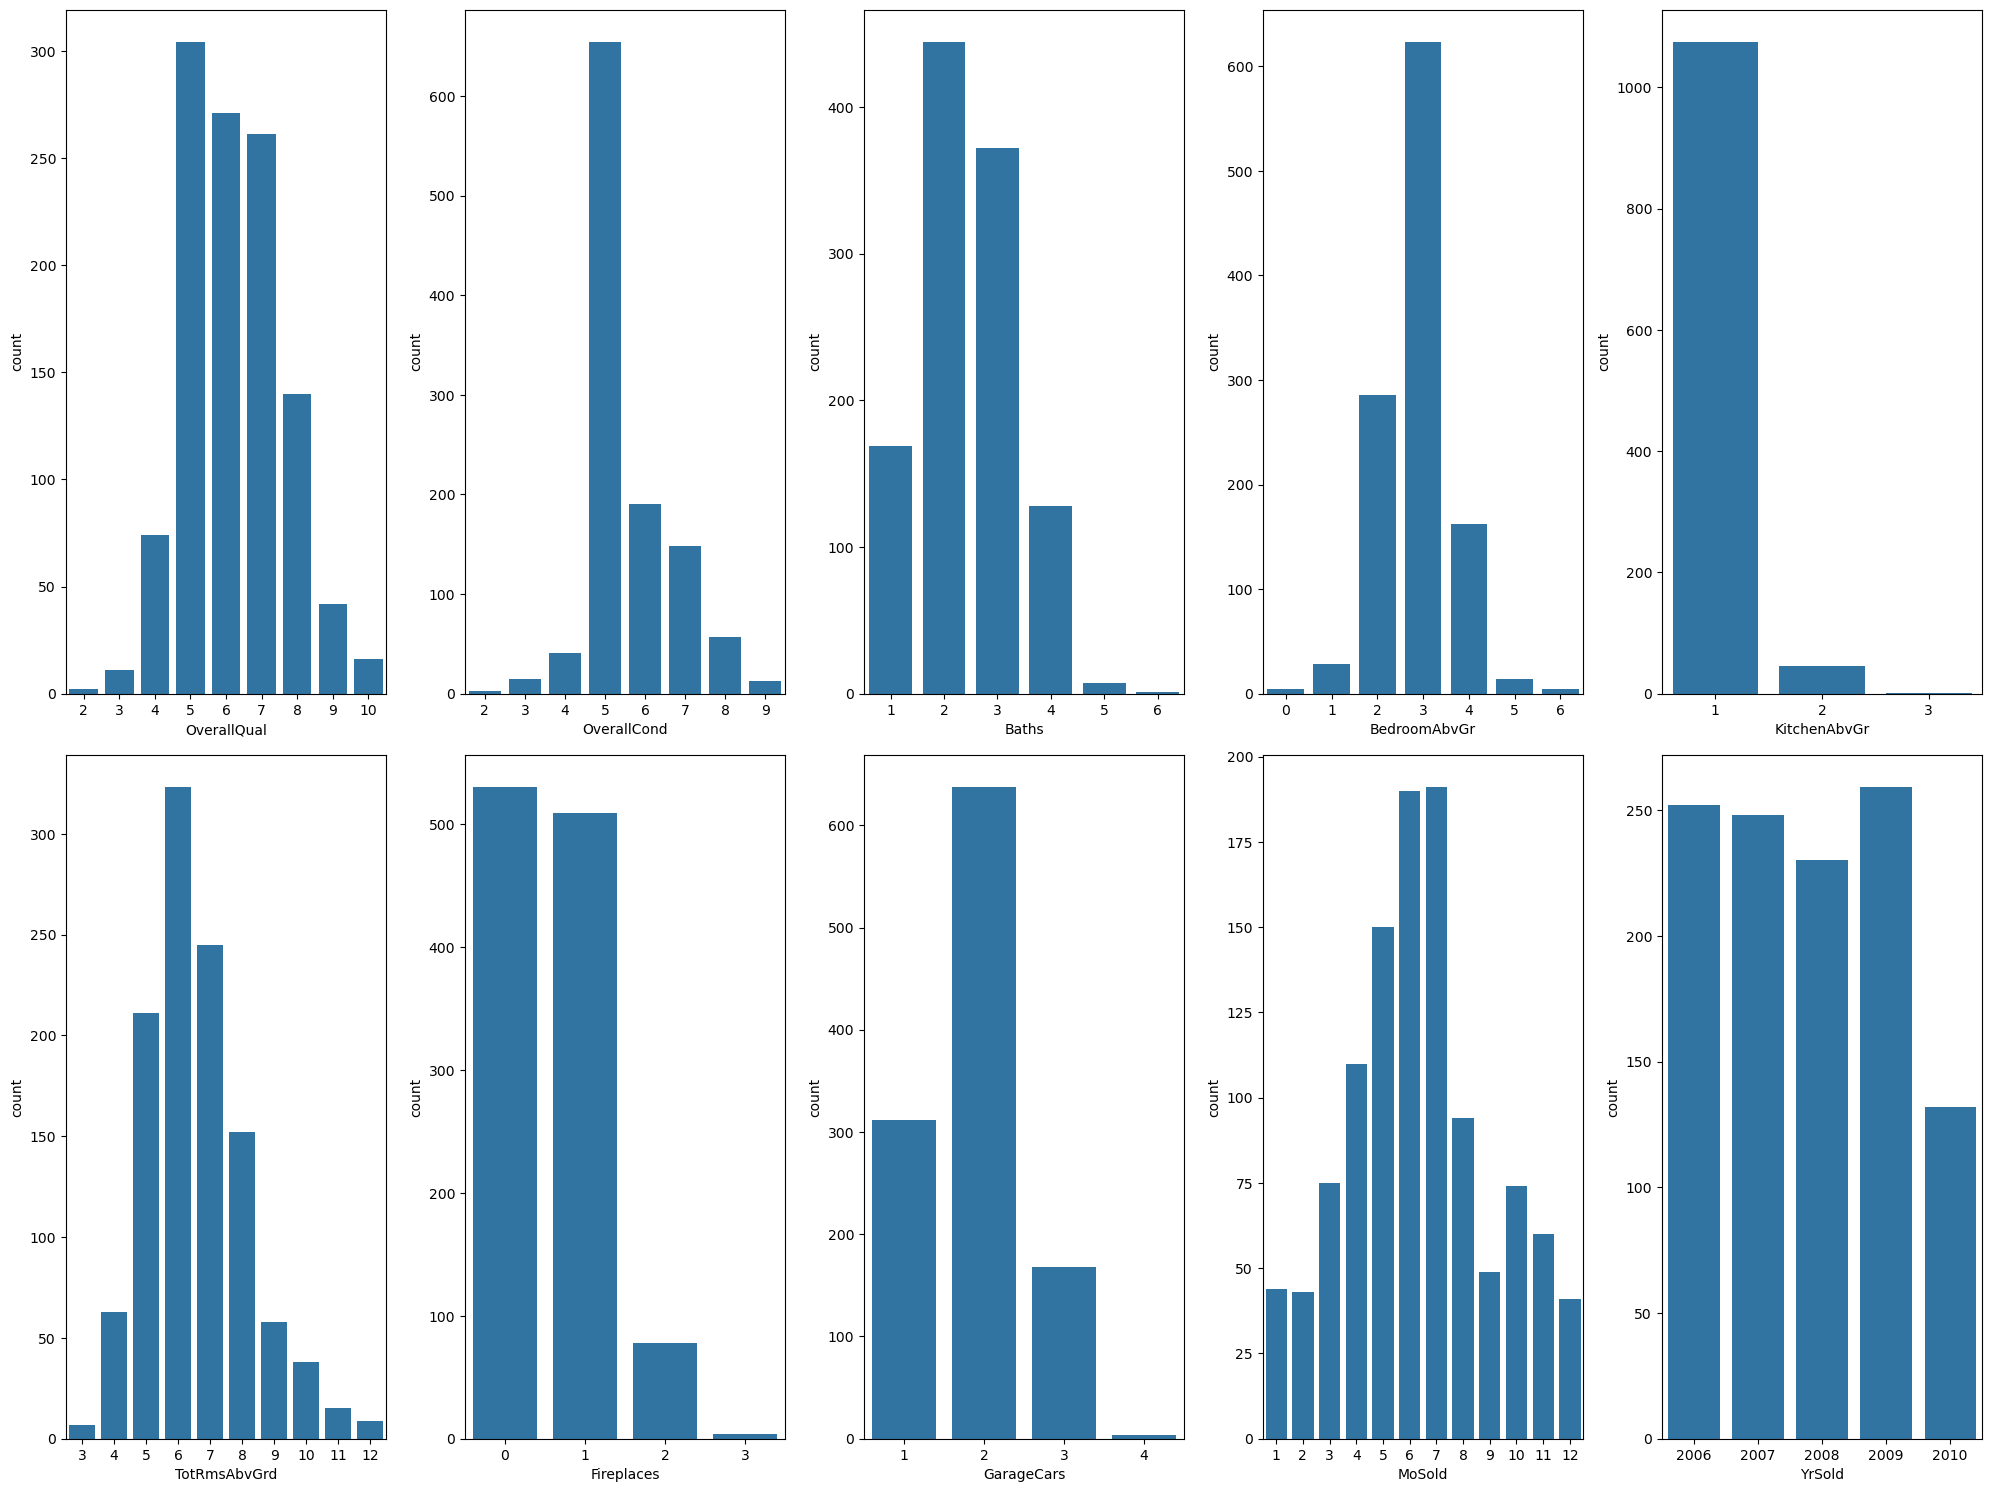

In [12]:
# remove features with extreme outliers
values_to_remove = ["LotFrontage", "LotArea", "MasVnrArea", "TotalBsmtSF", "GrLivArea", "PorchArea"]
data = data.drop(values_to_remove, axis = 1)
cont_num_var = [x for x in cont_num_var if x not in values_to_remove]

fig = plt.figure(figsize=(20,15))
for index,col in enumerate(disc_num_var):
    plt.subplot(2,5,index+1)
    sns.countplot(x=col, data=numeric_.dropna())
fig.tight_layout(pad=1.0)

## For categorical data, we use countplots to visualize the count of each distinct value within each features.

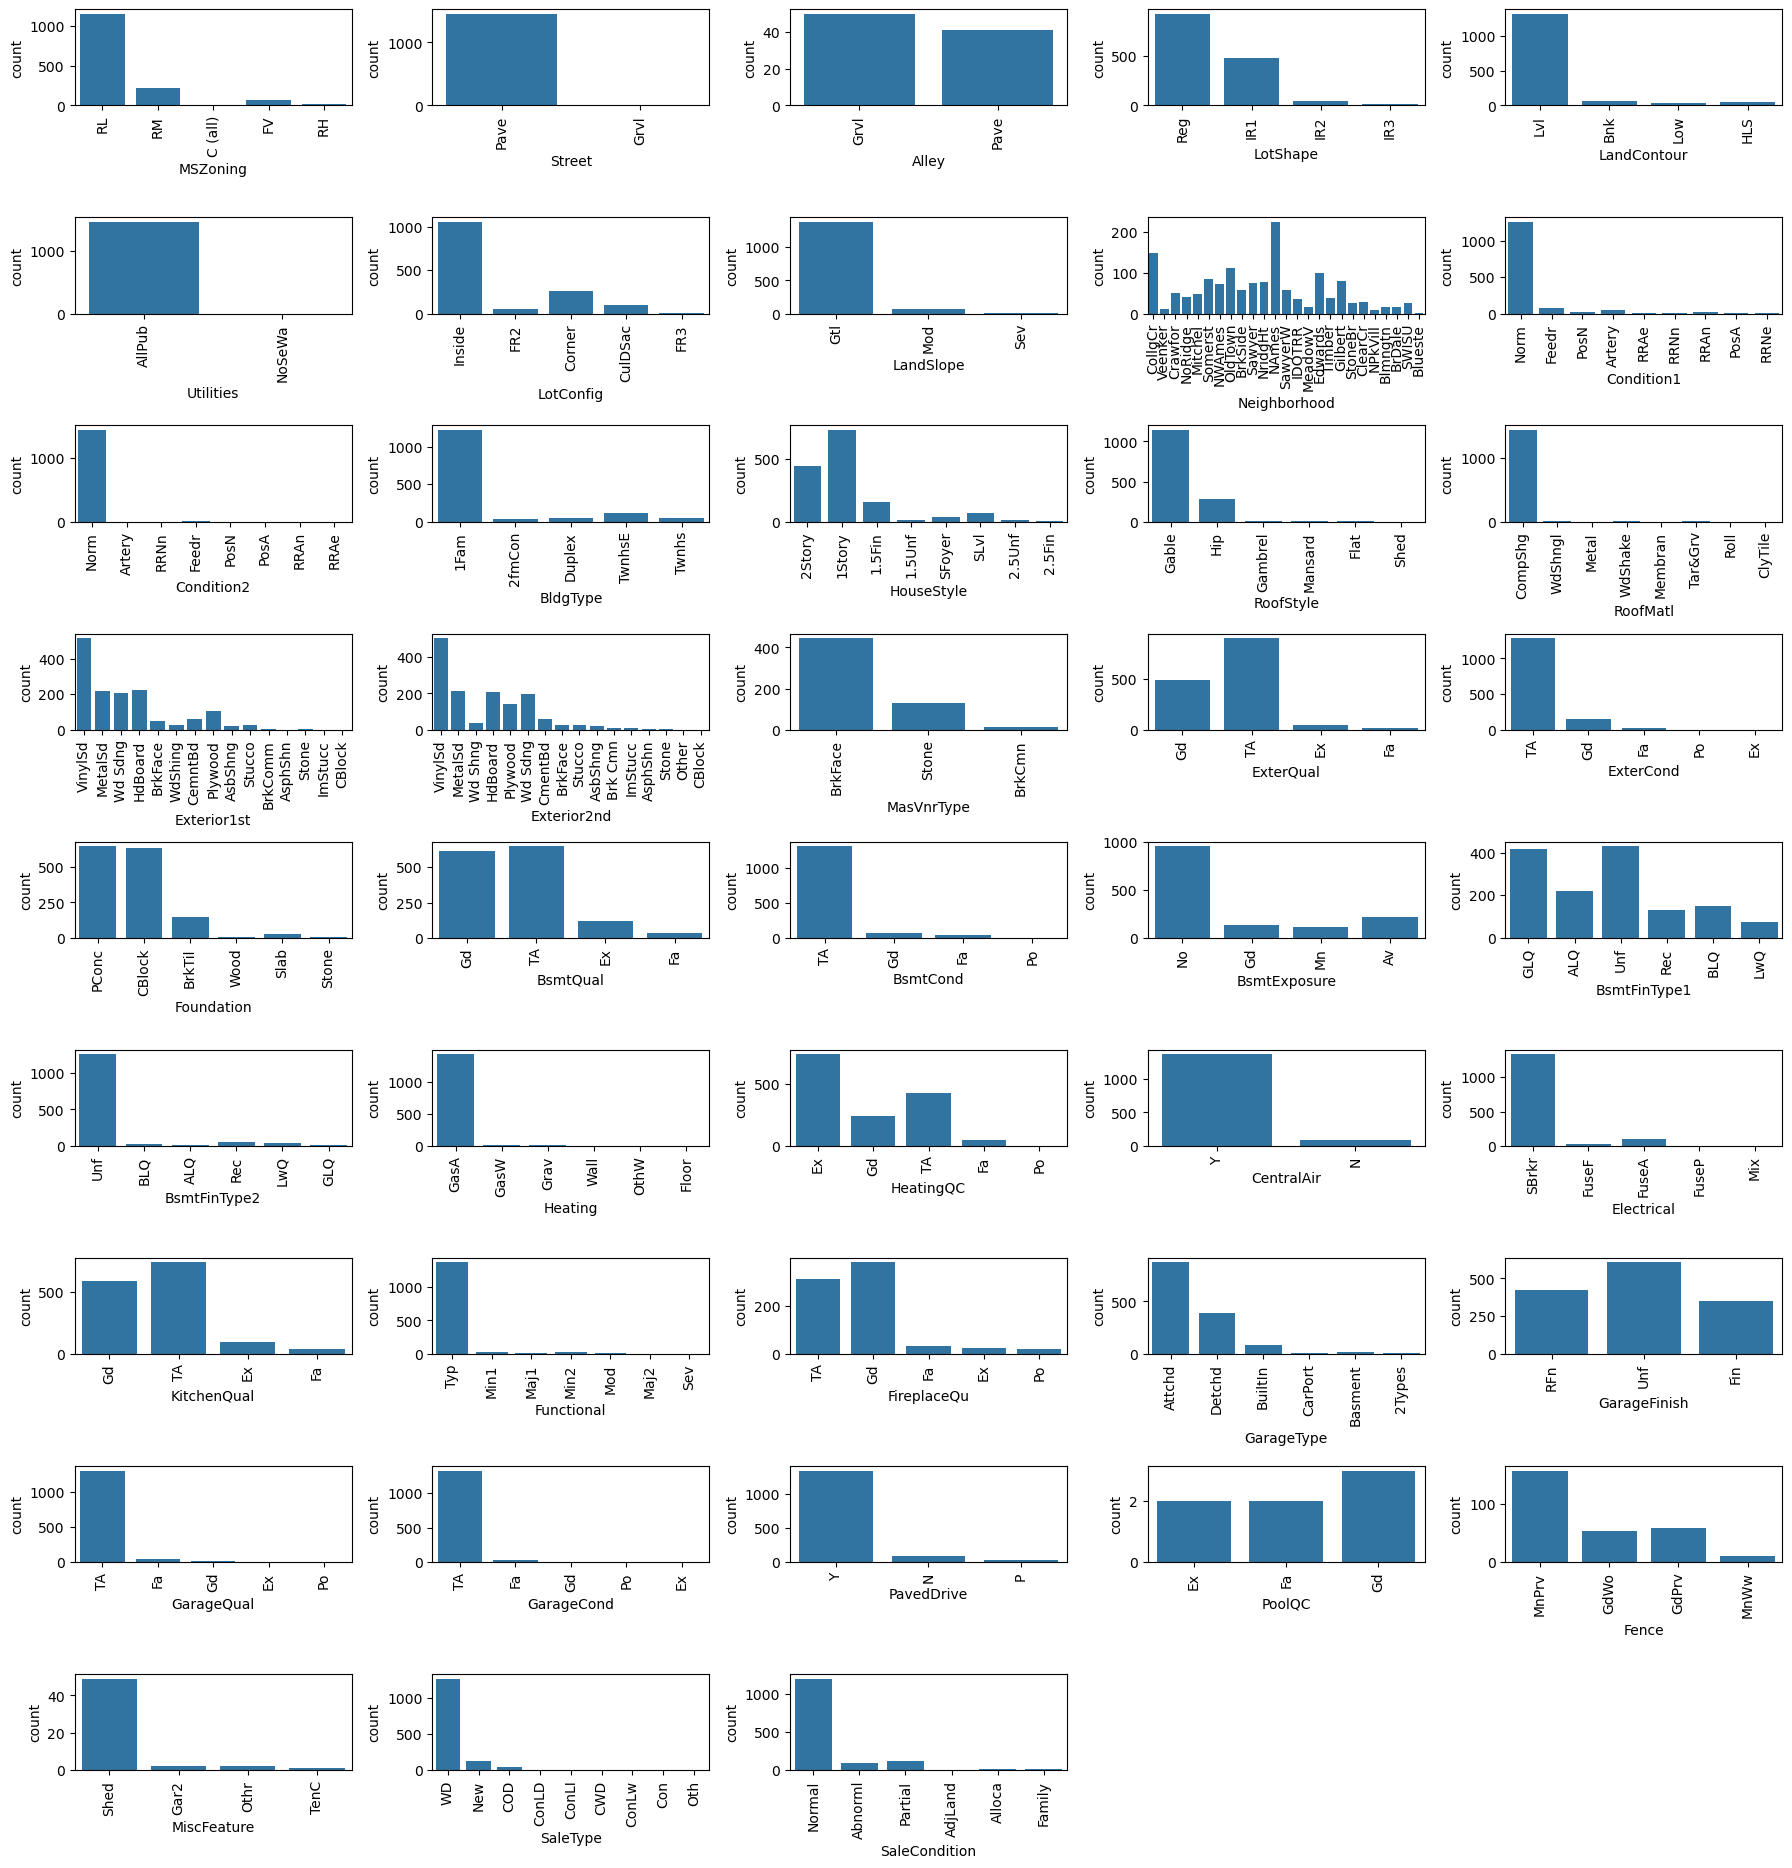

In [14]:
fig = plt.figure(figsize=(18,20))
for index in range(len(cat_vars.columns)):
    plt.subplot(10,5,index+1)
    sns.countplot(x=cat_vars.iloc[:,index], data=cat_vars.dropna())
    plt.xticks(rotation=90)
fig.tight_layout(pad=1.0)

## If a column has more than 96% of the same value, we will render the feature to be useless and remove it

In [16]:
cat_col = data.select_dtypes(include=['object']).columns
overfit_cat = []
for i in cat_col:
    counts = data[i].value_counts()
    zeros = counts.iloc[0]
    if zeros / len(data) * 100 > 96:
        overfit_cat.append(i)

data = data.drop(overfit_cat, axis=1)

In [17]:
num_col = data.select_dtypes(exclude=['object']).drop(['MSSubClass'], axis=1).columns
overfit_num = []
for i in num_col:
    counts = data[i].value_counts()
    zeros = counts.iloc[0]
    if zeros / len(data) * 100 > 96:
        overfit_num.append(i)

data = data.drop(overfit_num, axis=1)

print("Categorical Features with >96% of the same value: ",overfit_cat)
print("Numerical Features with >96% of the same value: ",overfit_num)

Categorical Features with >96% of the same value:  ['Street', 'Utilities', 'Condition2', 'RoofMatl', 'Heating']
Numerical Features with >96% of the same value:  []


In [18]:
num_vars = data.select_dtypes(include='number')
cat_vars = data.select_dtypes(include=['object', 'category'])

### We drop 'Street', 'Utilities', 'Condition2', 'RoofMatl', 'Heating'. 

## Correlation Matrix: 
- 1. The realtion bewteen saleprice and feature
- 2. investigate any multicollinearity between our independent predictors

<Axes: >

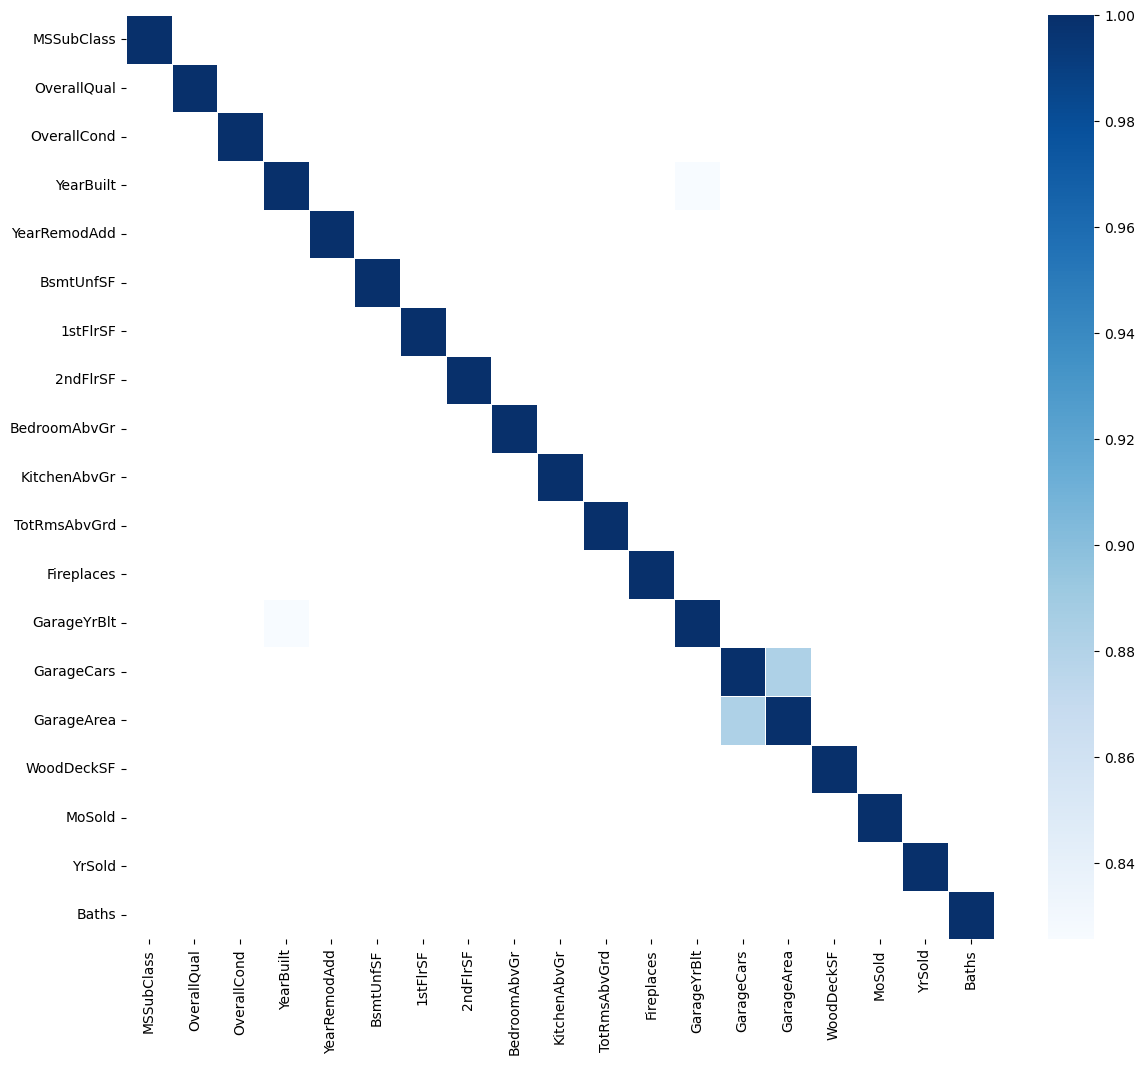

In [21]:
plt.figure(figsize=(14,12))
correlation = num_vars.corr()
sns.heatmap(correlation, mask = correlation <0.8, linewidth=0.5, cmap='Blues')

## Highly Correlated variables:

- GarageYrBlt and YearBuilt
- GarageArea and GarageCars

# Between Saleprice and numeric features

In [24]:
numeric_train = pd.concat([num_vars, train_with_y[["SalePrice"]]], axis = 1)
correlation = numeric_train.corr()
correlation[['SalePrice']].sort_values(['SalePrice'], ascending=False)

,SalePrice
SalePrice,1.000000
OverallQual,0.790982
GarageCars,0.640409
GarageArea,0.623431
Baths,0.613005
1stFlrSF,0.605852
TotRmsAbvGrd,0.533723
YearBuilt,0.522897
YearRemodAdd,0.507101
GarageYrBlt,0.486362


### OverallQual and GrLivArea have the strongest linear relationship with SalePrice. Hence, these 2 features will be important factor in predicting Housing Price

## Using scatterplot can also help us to identify potential linear relationship between Numerical features

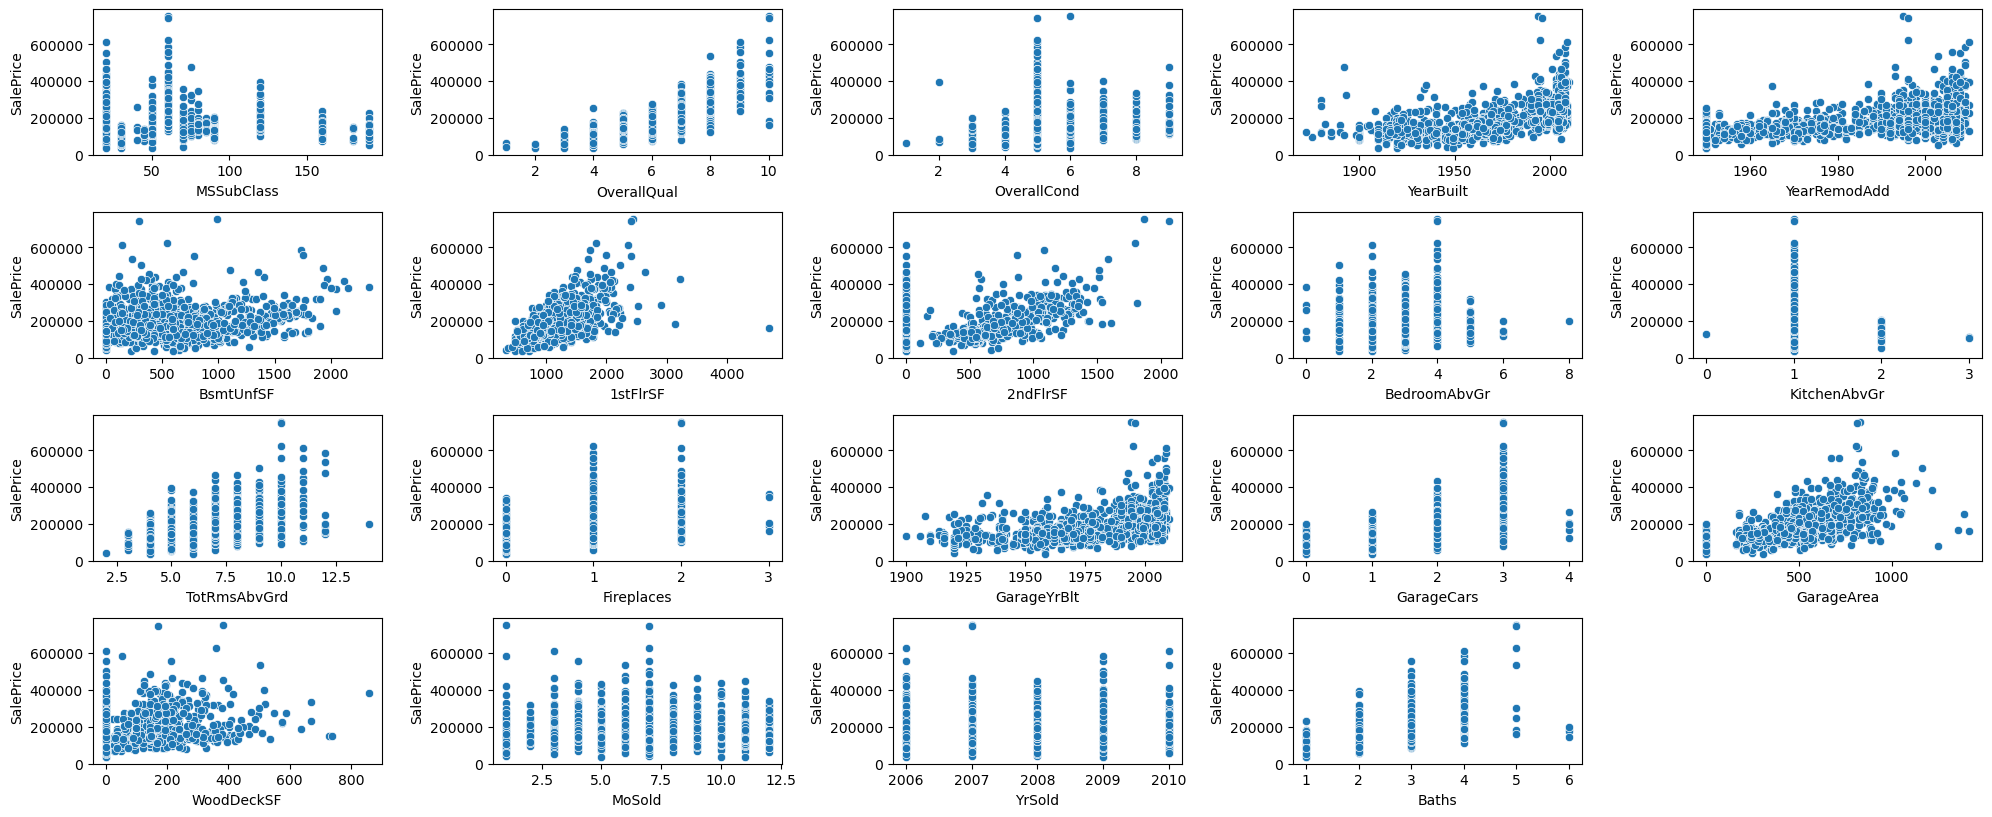

In [27]:
features = [col for col in numeric_train.columns if col != "SalePrice"]

fig = plt.figure(figsize=(20, 20))
for index, col in enumerate(features):
    plt.subplot(10, 5, index + 1)
    sns.scatterplot(x=numeric_train[col], y=numeric_train["SalePrice"])
plt.tight_layout(pad=1.0)

### We do not perform visualization and analysis just to create pretty graphs or for the sake of doing it, IT IS VITAL TO OUR PREPROCESSING!

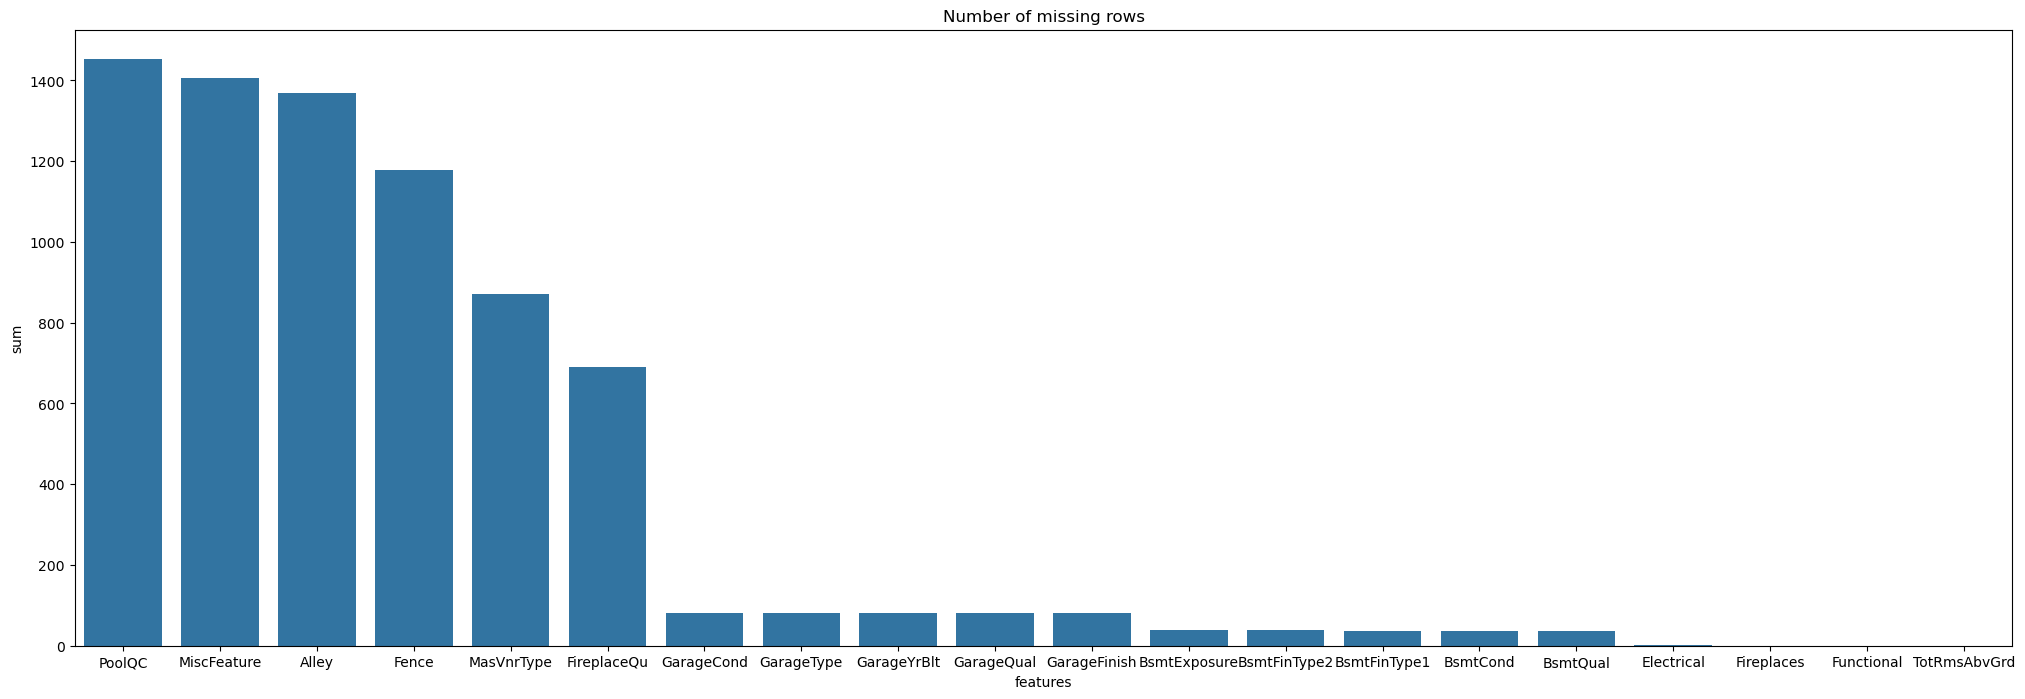

In [29]:
plt.figure(figsize=(25,8))
plt.title('Number of missing rows')
missing_count = pd.DataFrame(data.isnull().sum(), columns=['sum']).sort_values(by=['sum'],ascending=False).head(20).reset_index()
missing_count.columns = ['features','sum']
sns.barplot(x='features',y='sum', data = missing_count)
fig.savefig("missingvalues.png", dpi=300, bbox_inches='tight')

## Since variables 'PoolQC','MiscFeature', and 'Alley' have many missing rows, we drop them. 

In [31]:
values_to_remove = ["PoolQC", "MiscFeature", "Alley"]
data = data.drop(values_to_remove, axis = 1)
num_vars = data.select_dtypes(include='number')
cat_vars = data.select_dtypes(include=['object', 'category'])

 ## We will also remove features that does not have any linear relationship with target SalePrice

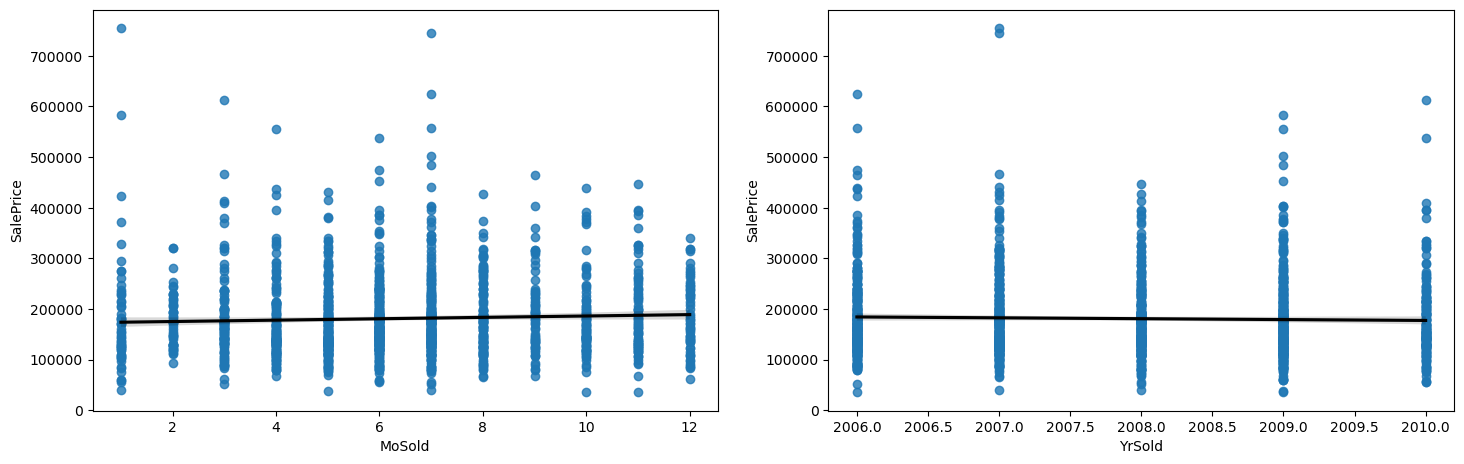

In [33]:
fig,axes = plt.subplots(1,2, figsize=(15,5))
sns.regplot(x=numeric_train['MoSold'], y='SalePrice', data=numeric_train, ax = axes[0], line_kws={'color':'black'})
sns.regplot(x=numeric_train['YrSold'], y='SalePrice', data=numeric_train, ax = axes[1],line_kws={'color':'black'})
fig.tight_layout(pad=2.0)

In [34]:
values_to_remove = ["MoSold", "YrSold"]
data = data.drop(values_to_remove, axis = 1)
num_vars = data.select_dtypes(include='number')
cat_vars = data.select_dtypes(include=['object', 'category'])

In [35]:
# Categorical Features that makes sense to turn into a binary feature
colum = ['2ndFlrSF','WoodDeckSF']

for col in colum:
    col_name = col+'_bin'
    data[col_name] = data[col].apply(lambda x: 1 if x > 0 else 0)

In [36]:
# Turning Categorical Features into Continuous
data = pd.get_dummies(data)

In [37]:
from sklearn.model_selection import train_test_split
X = data
y = train_with_y["SalePrice"]
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, random_state=42)

In [38]:
# Random Forest
rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf.fit(X_train, y_train)

# R^2
rf.score(X_valid, y_valid)

0.8868499674993932

In [39]:
# RMSE
y_pred = rf.predict(X_valid)
rmse = root_mean_squared_error(y_valid, y_pred)
print(f"RMSE: {rmse:.3f}")
print(f"Mean of target (y_valid): {y_valid.mean():.3f}")
print(f"Std dev of target (y_valid): {y_valid.std():.3f}")

RMSE: 29460.103
Mean of target (y_valid): 178839.812
Std dev of target (y_valid): 87730.751


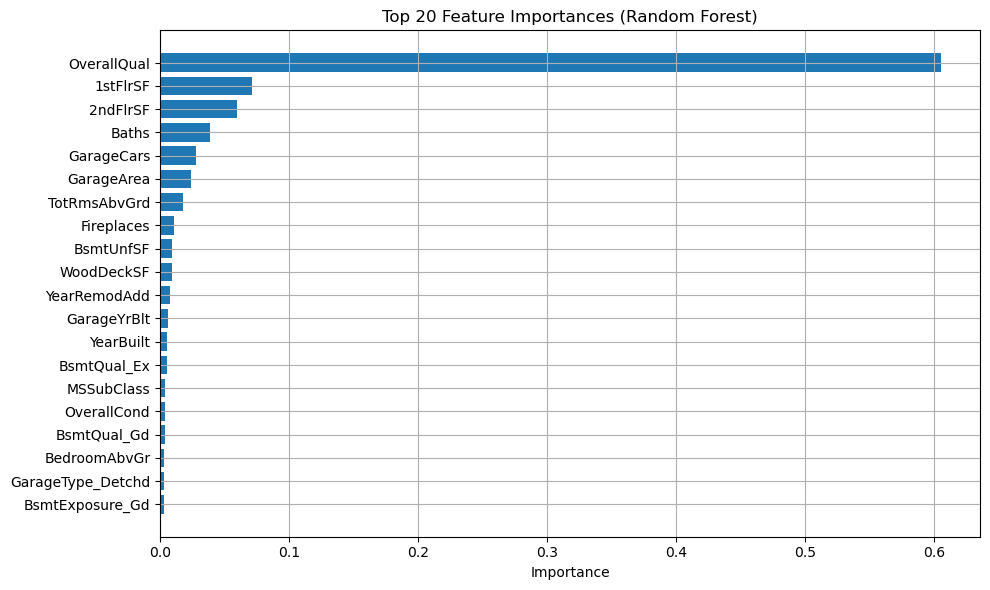

In [40]:
importances = rf.feature_importances_
feature_names = X_train.columns

# Create DataFrame
feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False).head(20)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(feat_imp_df['Feature'], feat_imp_df['Importance'])
plt.gca().invert_yaxis()
plt.title('Top 20 Feature Importances (Random Forest)')
plt.xlabel('Importance')
plt.tight_layout()
plt.grid(True)
plt.show()

In [41]:
# XGBoost
xgb = XGBRegressor(booster='gbtree', objective='reg:squarederror')

param_lst = {
    'learning_rate': [0.01, 0.1, 0.15, 0.3, 0.5],
    'n_estimators': [100, 500, 1000, 2000],
    'max_depth': [3, 6, 9],
    'min_child_weight': [1, 5, 10],
    'reg_alpha': [0.001, 0.01, 0.1],
    'reg_lambda': [0.001, 0.01, 0.1]
}


In [42]:
xgb_reg = RandomizedSearchCV(
    estimator = xgb,
    param_distributions = param_lst,
    n_iter = 4, 
    scoring = 'neg_root_mean_squared_error',
    cv = 3,
    verbose = 1,
    n_jobs = -1
)

xgb_search = xgb_reg.fit(X_train, y_train)
best_param = xgb_search.best_params_

Fitting 3 folds for each of 4 candidates, totalling 12 fits


In [43]:
xgb_best = XGBRegressor(**best_param)
xgb_best.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.15, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=5, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, ...)

In [44]:
# R^2
xgb_best.score(X_valid, y_valid)

0.9006837010383606

In [45]:
# RMSE
y_pred = xgb_best.predict(X_valid)
rmse = root_mean_squared_error(y_valid, y_pred)
print(f"RMSE: {rmse:.3f}")
print(f"Mean of target (y_valid): {y_valid.mean():.3f}")
print(f"Std dev of target (y_valid): {y_valid.std():.3f}")

RMSE: 27600.512
Mean of target (y_valid): 178839.812
Std dev of target (y_valid): 87730.751


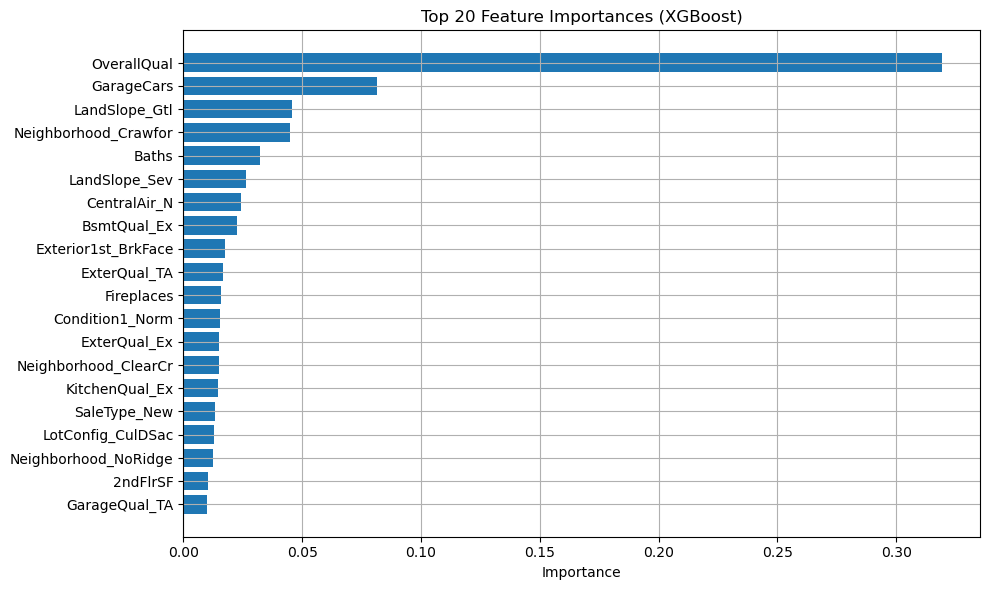

In [46]:
importances = xgb_best.feature_importances_
feature_names = X_train.columns

# Create DataFrame
xgb_feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False).head(20)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(xgb_feat_imp_df['Feature'], xgb_feat_imp_df['Importance'])
plt.gca().invert_yaxis()
plt.title('Top 20 Feature Importances (XGBoost)')
plt.xlabel('Importance')
plt.tight_layout()
plt.grid(True)
plt.show()

In [47]:
# Bagging
base_tree = DecisionTreeRegressor()

# Define Bagging Regressor
bagging = BaggingRegressor(estimator=base_tree)

valid_bagging_keys = [
    'n_estimators', 'max_samples', 'max_features', 'bootstrap',
    'estimator__max_depth', 'estimator__min_samples_split'
]

# Filter out invalid params (e.g., reg_lambda from XGBoost)
cleaned_best_param = {k: v for k, v in best_param.items() if k in valid_bagging_keys}

# Split into bagging vs base estimator params
tree_params = {k.replace('estimator__', ''): v for k, v in cleaned_best_param.items() if k.startswith('estimator__')}
bagging_params = {k: v for k, v in cleaned_best_param.items() if not k.startswith('estimator__')}

# Proceed as before
tuned_tree = DecisionTreeRegressor(**tree_params)
bagging_best = BaggingRegressor(estimator=tuned_tree, **bagging_params)
bagging_best.fit(X_train, y_train)

BaggingRegressor(estimator=DecisionTreeRegressor(), n_estimators=1000)

In [48]:
test_r2 = bagging_best.score(X_valid, y_valid)
print(f"Test R²: {test_r2:.3f}")

Test R²: 0.887


In [49]:
# RMSE
y_pred = bagging_best.predict(X_valid)
rmse = root_mean_squared_error(y_valid, y_pred)
print(f"RMSE: {rmse:.3f}")
print(f"Mean of target (y_valid): {y_valid.mean():.3f}")
print(f"Std dev of target (y_valid): {y_valid.std():.3f}")

RMSE: 29384.969
Mean of target (y_valid): 178839.812
Std dev of target (y_valid): 87730.751


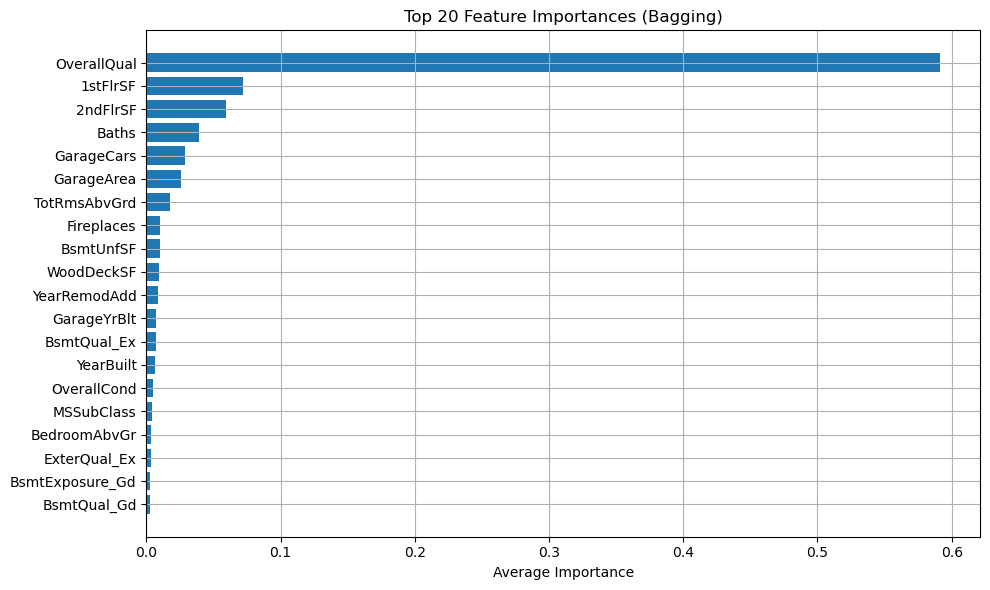

In [50]:
feature_names = X_train.columns

# Get feature importances from each base estimator
tree_importances = np.array([
    tree.feature_importances_ for tree in bagging_best.estimators_
])

# Average across all trees
avg_importances = tree_importances.mean(axis=0)

# Create DataFrame
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': avg_importances
}).sort_values(by='Importance', ascending=False)

feature_importance_df = feature_importance_df.head(20)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.gca().invert_yaxis()
plt.title('Top 20 Feature Importances (Bagging)')
plt.xlabel('Average Importance')
plt.grid(True)
plt.tight_layout()
plt.show()